In [1]:
import numpy as np
from pathlib import Path
from PIL import Image
from torch.utils.data import DataLoader, random_split
import torch
from torch import optim
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import logging
from evaluate import evaluate

import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import OrderedDict

from model.ensemblenet_model import EnsembleNet


from utils.dice_score import dice_loss
from utils.data_load import KittiDataset
from torchsummaryX import summary

In [2]:
Val_Percent = 0.3
Scale_Percent = 1.0
Batch_Size = 8
learning_rate = 0.0001
Pin_Memory = False
epochs = 50


Image_Size = [384, 1216]
Gradient_Clipping = 0.8


Num_Class = 2
Num_Channel = 3
amp = True

Model_Name = 'ensemble_fusion'


Img_Path =  'data/data_road/training/image_2'
Mask_Path =  'data/data_road/training/semantic'

save_checkpoint = True
checkpoint_dir = '../trained' + '_' + Model_Name
batch_size = Batch_Size

In [3]:
dirImg = Path(Img_Path)
dirMask = Path(Mask_Path)
dir_checkpoint = Path(checkpoint_dir)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
datasets =  KittiDataset(dirImg, dirMask, Image_Size, Scale_Percent)
n_val = int(len(datasets) * Val_Percent)
n_train = len(datasets) - n_val
train_set, val_set = random_split(datasets, [n_train, n_val], generator=torch.Generator().manual_seed(0))

loader_args = dict(batch_size=Batch_Size, num_workers= os.cpu_count(), pin_memory=Pin_Memory)
train_loader = DataLoader(train_set, shuffle=True, drop_last = True, **loader_args)
val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

100%|██████████| 289/289 [00:00<00:00, 870.42it/s]


In [6]:
model = EnsembleNet(Model_Name, Num_Channel, Num_Class)
model = model.to(memory_format=torch.channels_last, device = device)

In [7]:
# 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
#optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)

if 'ensemble_voting' in Model_Name:
    unet_optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    segnet_optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    enet_optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    optims = [unet_optimizer, segnet_optimizer, enet_optimizer]
    
    unet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(unet_optimizer, 'max', patience=2)  # goal: maximize Dice score
    segnet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(segnet_optimizer, 'max', patience=2)  # goal: maximize Dice score
    enet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(enet_optimizer, 'max', patience=2)  # goal: maximize Dice score
       
else:
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-10)
    #optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-10)
    optims = [optimizer]
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score

grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
criterion = nn.CrossEntropyLoss()
global_step = 0

In [8]:
def calculate_loss(pred, true_masks, nclass, multiclass):
    loss = criterion(pred, true_masks)
    loss += dice_loss(
        F.softmax(pred, dim=1).float(),
        F.one_hot(true_masks, nclass).permute(0, 3, 1, 2).float(),
        multiclass=multiclass
    )
    return loss

def grad_forback(models, losses, optim):
    optim.zero_grad(set_to_none=True)
    grad_scaler.scale(losses).backward()
    torch.nn.utils.clip_grad_norm_(models.parameters(), Gradient_Clipping)
    grad_scaler.step(optim)
    grad_scaler.update()    

def forward_and_backward(model, images, true_masks, amp, optimizers, grad_scaler, model_name):
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        
        try:
            mn_cls = model.n_classes
        except:
            mn_cls = model.classifier[-1].out_channels

        if model_name == 'ensemble_voting':
            unet_pred, segnet_pred, enet_pred = model(images)
            #deeplab_pred = deeplab_pred['out']
            
            unet_loss = calculate_loss(unet_pred, true_masks, mn_cls, multiclass=True)
            segnet_loss = calculate_loss(segnet_pred, true_masks, mn_cls, multiclass=True)
            enet_loss = calculate_loss(enet_pred, true_masks, mn_cls, multiclass=True)
            
            
        else:
            masks_pred = model(images)
            if isinstance(masks_pred, OrderedDict):
                masks_pred = masks_pred['out']
            loss = calculate_loss(masks_pred, true_masks, mn_cls, multiclass=True)
    
    
    if model_name == 'ensemble_voting':
        for _loss, _optiz in zip([unet_loss, segnet_loss, enet_loss], optimizers):
            grad_forback(model, _loss, _optiz)

        return model, unet_loss, segnet_loss, enet_loss
    else:
        for _loss, _optiz in zip([loss], optimizers):
            grad_forback(model, _loss, _optiz)
            
        return model, loss


In [9]:
valScore_list1 = []
TrainLoss_list1 = []

valScore_list2 = []
TrainLoss_list2 = []

valScore_list3 = []
TrainLoss_list3 = []

valScore_list4 = []
TrainLoss_list4 = []

val_losses = []
val_accs = []
val_mious = []

# 5. Begin training
for epoch in range(1, epochs + 1):
    model.train()
    epoch_loss = 0
    epoch_unet_loss = 0
    epoch_segnet_loss = 0
    epoch_enet_loss = 0
    epoch_voting_loss = 0
    
    with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
        for batch in train_loader:
            images, true_masks = batch['image'], batch['mask']

            images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            true_masks = true_masks.to(device=device, dtype=torch.long)

                
            result = forward_and_backward(model, images, true_masks, amp, optims, grad_scaler, Model_Name)
            
            if len(result) == 4:
                model, unet_loss, segnet_loss, enet_loss = result
                
                pbar.update(images.shape[0])
                global_step += 1
                epoch_unet_loss += unet_loss.item()
                epoch_segnet_loss += segnet_loss.item()
                epoch_enet_loss += enet_loss.item()
                vot_loss = ((unet_loss.item() + segnet_loss.item() + enet_loss.item()) /3)
                epoch_voting_loss += vot_loss
                
                
            elif len(result) == 2:
                model, loss = result
                
                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()


        print('***')
        if len(result) == 4:
            print('Unet Loss: {}     Segnet Loss: {}     Enet Loss: {}'.format(unet_loss, segnet_loss, enet_loss))
            print('Voting Loss: {}'.format(vot_loss))
            
            
        elif len(result) == 2:
            print('{} Loss: {}'.format(Model_Name, loss))

        # Evaluation round
        division_step = (n_train // (5 * batch_size))
        if division_step > 0:
            #if global_step % division_step == 0:
            if len(result) == 4:
                unet_val_score, segnet_val_score, enet_val_score, voting_val_score, val_loss, val_acc, val_miou = evaluate(model, val_loader, criterion, device, Model_Name, amp)
                
                unet_scheduler.step(unet_val_score)
                segnet_scheduler.step(segnet_val_score)
                enet_scheduler.step(enet_val_score)
                #voting_scheduler.step(voting_val_score)
                
                valScore_list1.append(unet_val_score.cpu().detach().numpy())
                TrainLoss_list1.append(unet_loss.cpu().detach().numpy())
                valScore_list2.append(segnet_val_score.cpu().detach().numpy())
                TrainLoss_list2.append(segnet_loss.cpu().detach().numpy())                
                valScore_list3.append(enet_val_score.cpu().detach().numpy())
                TrainLoss_list3.append(enet_loss.cpu().detach().numpy())
                valScore_list4.append(voting_val_score.cpu().detach().numpy())
                TrainLoss_list4.append(vot_loss)
                
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                val_mious.append(val_miou)
                
                print('---')
                print('Unet Validation Dice Score: {}     Segnet Validation Dice Score: {}     Enet Validation Dice Score: {}'.format(unet_val_score, segnet_val_score, enet_val_score))
                print('---')
                print('Ensemble Voting Validation Dice Loss: {}'.format(val_loss))
                print('Ensemble Voting Validation Pixel Accuracy: {} '.format(val_acc))
                print('Ensemble Voting Validation MIoU: {}'.format(val_miou))                
                print('Ensemble Voting Validation Dice Score: {} '.format(voting_val_score))
                
            else:
                val_score, val_loss, val_acc, val_miou = evaluate(model, val_loader, criterion, device, Model_Name, amp)
                
                                
                scheduler.step(val_score)
                
                print('---')
                print('{} Validation Dice Loss: {}'.format(Model_Name, val_loss))   
                print('{} Validation Pixel Accuracy: {}'.format(Model_Name, val_acc))
                print('{} Validation MIoU: {}'.format(Model_Name, val_miou))
                print('{} Validation Dice Score: {}'.format(Model_Name, val_score))
                
            
                valScore_list1.append(val_score.cpu().detach().numpy())
                TrainLoss_list1.append(loss.cpu().detach().numpy())
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                val_mious.append(val_miou)

        
    if save_checkpoint:
        Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
        torch.save(model.state_dict(), str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch + 1)))

Epoch 1/50:  99%|█████████▊| 200/203 [00:17<00:00, 15.34img/s]

***
ensemble_fusion Loss: 0.8761351704597473


Epoch 1/50:  99%|█████████▊| 200/203 [00:21<00:00,  9.38img/s]

---
ensemble_fusion Validation Dice Loss: 1.0869286060333252
ensemble_fusion Validation Pixel Accuracy: 0.8481000933730811
ensemble_fusion Validation MIoU: 0.42405004668654067
ensemble_fusion Validation Dice Score: 3.3779972000047565e-05



Epoch 2/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.41img/s]

***
ensemble_fusion Loss: 0.7566758394241333


Epoch 2/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.60img/s]

---
ensemble_fusion Validation Dice Loss: 1.10153067111969
ensemble_fusion Validation Pixel Accuracy: 0.6938091077302632
ensemble_fusion Validation MIoU: 0.48089112963411784
ensemble_fusion Validation Dice Score: 0.5443295836448669



Epoch 3/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.38img/s]

***
ensemble_fusion Loss: 0.7615532875061035


Epoch 3/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.71img/s]

---
ensemble_fusion Validation Dice Loss: 0.7737569808959961
ensemble_fusion Validation Pixel Accuracy: 0.8853315386855811
ensemble_fusion Validation MIoU: 0.7074911086688842
ensemble_fusion Validation Dice Score: 0.7290176749229431



Epoch 4/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.28img/s]

***
ensemble_fusion Loss: 0.7430963516235352


Epoch 4/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.63img/s]

---
ensemble_fusion Validation Dice Loss: 0.7714023590087891
ensemble_fusion Validation Pixel Accuracy: 0.8726493433902138
ensemble_fusion Validation MIoU: 0.6892634136375952
ensemble_fusion Validation Dice Score: 0.7188031077384949



Epoch 5/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.17img/s]

***
ensemble_fusion Loss: 0.6814055442810059


Epoch 5/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.62img/s]

---
ensemble_fusion Validation Dice Loss: 0.6811063289642334
ensemble_fusion Validation Pixel Accuracy: 0.9179288629899945
ensemble_fusion Validation MIoU: 0.7588844744176022
ensemble_fusion Validation Dice Score: 0.7742321491241455



Epoch 6/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.20img/s]

***
ensemble_fusion Loss: 0.6599850654602051


Epoch 6/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.61img/s]

---
ensemble_fusion Validation Dice Loss: 0.722851037979126
ensemble_fusion Validation Pixel Accuracy: 0.9171838593064693
ensemble_fusion Validation MIoU: 0.758655053937219
ensemble_fusion Validation Dice Score: 0.782162606716156



Epoch 7/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.45img/s]

***
ensemble_fusion Loss: 0.6338532567024231


Epoch 7/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.64img/s]

---
ensemble_fusion Validation Dice Loss: 0.6685800552368164
ensemble_fusion Validation Pixel Accuracy: 0.9227463571648848
ensemble_fusion Validation MIoU: 0.7725407746960233
ensemble_fusion Validation Dice Score: 0.7969995141029358



Epoch 8/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.26img/s]

***
ensemble_fusion Loss: 0.7063230276107788


Epoch 8/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.64img/s]

---
ensemble_fusion Validation Dice Loss: 0.688085675239563
ensemble_fusion Validation Pixel Accuracy: 0.9204952842310855
ensemble_fusion Validation MIoU: 0.7592686039737592
ensemble_fusion Validation Dice Score: 0.8040423393249512



Epoch 9/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.42img/s]

***
ensemble_fusion Loss: 0.6279897689819336


Epoch 9/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.67img/s]

---
ensemble_fusion Validation Dice Loss: 0.6551279425621033
ensemble_fusion Validation Pixel Accuracy: 0.9268664979098136
ensemble_fusion Validation MIoU: 0.7798597325208629
ensemble_fusion Validation Dice Score: 0.8087636232376099



Epoch 10/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.21img/s]

***
ensemble_fusion Loss: 0.6247209310531616


Epoch 10/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.65img/s]

---
ensemble_fusion Validation Dice Loss: 0.6779279708862305
ensemble_fusion Validation Pixel Accuracy: 0.9323358368455318
ensemble_fusion Validation MIoU: 0.7850048143789099
ensemble_fusion Validation Dice Score: 0.7902219891548157



Epoch 11/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.47img/s]

***
ensemble_fusion Loss: 0.6444939970970154


Epoch 11/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.72img/s]

---
ensemble_fusion Validation Dice Loss: 0.67861008644104
ensemble_fusion Validation Pixel Accuracy: 0.9250287507709704
ensemble_fusion Validation MIoU: 0.7804122144135455
ensemble_fusion Validation Dice Score: 0.8114632964134216



Epoch 12/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.32img/s]

***
ensemble_fusion Loss: 0.5934855937957764


Epoch 12/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.65img/s]

---
ensemble_fusion Validation Dice Loss: 0.6500270366668701
ensemble_fusion Validation Pixel Accuracy: 0.9373417904502467
ensemble_fusion Validation MIoU: 0.8009717138423221
ensemble_fusion Validation Dice Score: 0.8276587724685669



Epoch 13/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.33img/s]

***
ensemble_fusion Loss: 0.6139944195747375


Epoch 13/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.77img/s]

---
ensemble_fusion Validation Dice Loss: 0.6851285696029663
ensemble_fusion Validation Pixel Accuracy: 0.9292648047731634
ensemble_fusion Validation MIoU: 0.7907408288409388
ensemble_fusion Validation Dice Score: 0.8421805500984192



Epoch 14/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.21img/s]

***
ensemble_fusion Loss: 0.6066950559616089


Epoch 14/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.52img/s]

---
ensemble_fusion Validation Dice Loss: 0.6463273763656616
ensemble_fusion Validation Pixel Accuracy: 0.9237408554344847
ensemble_fusion Validation MIoU: 0.7367301125625625
ensemble_fusion Validation Dice Score: 0.7414812445640564



Epoch 15/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.36img/s]

***
ensemble_fusion Loss: 0.5743882656097412


Epoch 15/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.63img/s]

---
ensemble_fusion Validation Dice Loss: 0.6129518747329712
ensemble_fusion Validation Pixel Accuracy: 0.9470337984854715
ensemble_fusion Validation MIoU: 0.8261133759803931
ensemble_fusion Validation Dice Score: 0.8653097152709961



Epoch 16/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.32img/s]

***
ensemble_fusion Loss: 0.5642212629318237


Epoch 16/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.70img/s]

---
ensemble_fusion Validation Dice Loss: 0.6078230738639832
ensemble_fusion Validation Pixel Accuracy: 0.948797393263432
ensemble_fusion Validation MIoU: 0.8338315616674353
ensemble_fusion Validation Dice Score: 0.8323842883110046



Epoch 17/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.48img/s]

***
ensemble_fusion Loss: 0.571562647819519


Epoch 17/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.57img/s]

---
ensemble_fusion Validation Dice Loss: 0.6486621499061584
ensemble_fusion Validation Pixel Accuracy: 0.9240503143845943
ensemble_fusion Validation MIoU: 0.780535909856677
ensemble_fusion Validation Dice Score: 0.8285741209983826



Epoch 18/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.37img/s]

***
ensemble_fusion Loss: 0.5487264394760132


Epoch 18/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.72img/s]

---
ensemble_fusion Validation Dice Loss: 0.6261285543441772
ensemble_fusion Validation Pixel Accuracy: 0.937243009868421
ensemble_fusion Validation MIoU: 0.8102115544819215
ensemble_fusion Validation Dice Score: 0.8661805391311646



Epoch 19/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.31img/s]

***
ensemble_fusion Loss: 0.5891766548156738


Epoch 19/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.58img/s]

---
ensemble_fusion Validation Dice Loss: 0.6242808103561401
ensemble_fusion Validation Pixel Accuracy: 0.9415502715529057
ensemble_fusion Validation MIoU: 0.8109429607081915
ensemble_fusion Validation Dice Score: 0.871006190776825



Epoch 20/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.33img/s]

***
ensemble_fusion Loss: 0.5634157657623291


Epoch 20/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.71img/s]

---
ensemble_fusion Validation Dice Loss: 0.6377948522567749
ensemble_fusion Validation Pixel Accuracy: 0.9351434540330318
ensemble_fusion Validation MIoU: 0.7871935266121436
ensemble_fusion Validation Dice Score: 0.8488909602165222



Epoch 21/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.30img/s]

***
ensemble_fusion Loss: 0.5310739874839783


Epoch 21/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.66img/s]

---
ensemble_fusion Validation Dice Loss: 0.6437495946884155
ensemble_fusion Validation Pixel Accuracy: 0.931143509714227
ensemble_fusion Validation MIoU: 0.7963496387107678
ensemble_fusion Validation Dice Score: 0.8521995544433594



Epoch 22/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.32img/s]

***
ensemble_fusion Loss: 0.5353704690933228


Epoch 22/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.61img/s]

---
ensemble_fusion Validation Dice Loss: 0.5922206044197083
ensemble_fusion Validation Pixel Accuracy: 0.9502566153543037
ensemble_fusion Validation MIoU: 0.8345470286120236
ensemble_fusion Validation Dice Score: 0.8613702058792114



Epoch 23/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.34img/s]

***
ensemble_fusion Loss: 0.5301014184951782


Epoch 23/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.80img/s]

---
ensemble_fusion Validation Dice Loss: 0.5837021470069885
ensemble_fusion Validation Pixel Accuracy: 0.9488217537863213
ensemble_fusion Validation MIoU: 0.8338094635598308
ensemble_fusion Validation Dice Score: 0.8842386603355408



Epoch 24/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.57img/s]

***
ensemble_fusion Loss: 0.5398496389389038


Epoch 24/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.75img/s]

---
ensemble_fusion Validation Dice Loss: 0.578210711479187
ensemble_fusion Validation Pixel Accuracy: 0.9554628071032072
ensemble_fusion Validation MIoU: 0.8506818405593791
ensemble_fusion Validation Dice Score: 0.8885278105735779



Epoch 25/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.40img/s]

***
ensemble_fusion Loss: 0.5216575860977173


Epoch 25/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.67img/s]

---
ensemble_fusion Validation Dice Loss: 0.5715063810348511
ensemble_fusion Validation Pixel Accuracy: 0.9576175087376645
ensemble_fusion Validation MIoU: 0.8564833741751712
ensemble_fusion Validation Dice Score: 0.8901534080505371



Epoch 26/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.50img/s]

***
ensemble_fusion Loss: 0.5108619928359985


Epoch 26/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.57img/s]

---
ensemble_fusion Validation Dice Loss: 0.5668564438819885
ensemble_fusion Validation Pixel Accuracy: 0.9578322025767544
ensemble_fusion Validation MIoU: 0.8571695381364307
ensemble_fusion Validation Dice Score: 0.8897855877876282



Epoch 27/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.42img/s]

***
ensemble_fusion Loss: 0.5146389007568359


Epoch 27/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.68img/s]

---
ensemble_fusion Validation Dice Loss: 0.5665117502212524
ensemble_fusion Validation Pixel Accuracy: 0.9588847913240132
ensemble_fusion Validation MIoU: 0.8596785884220796
ensemble_fusion Validation Dice Score: 0.8910544514656067



Epoch 28/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.34img/s]

***
ensemble_fusion Loss: 0.5209636688232422


Epoch 28/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.64img/s]

---
ensemble_fusion Validation Dice Loss: 0.5706806182861328
ensemble_fusion Validation Pixel Accuracy: 0.9593326501679003
ensemble_fusion Validation MIoU: 0.8607162105634223
ensemble_fusion Validation Dice Score: 0.8992524147033691



Epoch 29/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.36img/s]

***
ensemble_fusion Loss: 0.5159148573875427


Epoch 29/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.60img/s]

---
ensemble_fusion Validation Dice Loss: 0.5647807121276855
ensemble_fusion Validation Pixel Accuracy: 0.9602883322197094
ensemble_fusion Validation MIoU: 0.8639107662283831
ensemble_fusion Validation Dice Score: 0.8961955308914185



Epoch 30/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.31img/s]

***
ensemble_fusion Loss: 0.5108088254928589


Epoch 30/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.60img/s]

---
ensemble_fusion Validation Dice Loss: 0.5659555792808533
ensemble_fusion Validation Pixel Accuracy: 0.958047164113898
ensemble_fusion Validation MIoU: 0.8578162345166789
ensemble_fusion Validation Dice Score: 0.89634770154953



Epoch 31/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.32img/s]

***
ensemble_fusion Loss: 0.5194578170776367


Epoch 31/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.75img/s]

---
ensemble_fusion Validation Dice Loss: 0.5670716762542725
ensemble_fusion Validation Pixel Accuracy: 0.9590553149842379
ensemble_fusion Validation MIoU: 0.8596654773297838
ensemble_fusion Validation Dice Score: 0.8980733156204224



Epoch 32/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.27img/s]

***
ensemble_fusion Loss: 0.5212926268577576


Epoch 32/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.62img/s]

---
ensemble_fusion Validation Dice Loss: 0.5645996928215027
ensemble_fusion Validation Pixel Accuracy: 0.9588143867358827
ensemble_fusion Validation MIoU: 0.8588657374320148
ensemble_fusion Validation Dice Score: 0.895678699016571



Epoch 33/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.50img/s]

***
ensemble_fusion Loss: 0.5214693546295166


Epoch 33/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.60img/s]

---
ensemble_fusion Validation Dice Loss: 0.567196249961853
ensemble_fusion Validation Pixel Accuracy: 0.9580300314384594
ensemble_fusion Validation MIoU: 0.857285090156138
ensemble_fusion Validation Dice Score: 0.8970061540603638



Epoch 34/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.32img/s]

***
ensemble_fusion Loss: 0.5259894728660583


Epoch 34/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.63img/s]

---
ensemble_fusion Validation Dice Loss: 0.5652894973754883
ensemble_fusion Validation Pixel Accuracy: 0.9581057899876645
ensemble_fusion Validation MIoU: 0.8579937664716892
ensemble_fusion Validation Dice Score: 0.8989483118057251



Epoch 35/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.51img/s]

***
ensemble_fusion Loss: 0.5127054452896118


Epoch 35/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.80img/s]

---
ensemble_fusion Validation Dice Loss: 0.5666849613189697
ensemble_fusion Validation Pixel Accuracy: 0.9581237257572642
ensemble_fusion Validation MIoU: 0.8578313624700993
ensemble_fusion Validation Dice Score: 0.8985673189163208



Epoch 36/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.51img/s]

***
ensemble_fusion Loss: 0.5222127437591553


Epoch 36/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.62img/s]

---
ensemble_fusion Validation Dice Loss: 0.565812885761261
ensemble_fusion Validation Pixel Accuracy: 0.9577411852384868
ensemble_fusion Validation MIoU: 0.8567397765602218
ensemble_fusion Validation Dice Score: 0.8984491229057312



Epoch 37/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.30img/s]

***
ensemble_fusion Loss: 0.5205265879631042


Epoch 37/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.63img/s]

---
ensemble_fusion Validation Dice Loss: 0.5637778043746948
ensemble_fusion Validation Pixel Accuracy: 0.9585102817468476
ensemble_fusion Validation MIoU: 0.8594293481498065
ensemble_fusion Validation Dice Score: 0.9001489877700806



Epoch 38/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.36img/s]

***
ensemble_fusion Loss: 0.5085561275482178


Epoch 38/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.52img/s]

---
ensemble_fusion Validation Dice Loss: 0.5622900724411011
ensemble_fusion Validation Pixel Accuracy: 0.9592528761478892
ensemble_fusion Validation MIoU: 0.8603944454841254
ensemble_fusion Validation Dice Score: 0.8983990550041199



Epoch 39/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.30img/s]

***
ensemble_fusion Loss: 0.5085155963897705


Epoch 39/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.64img/s]

---
ensemble_fusion Validation Dice Loss: 0.5625463128089905
ensemble_fusion Validation Pixel Accuracy: 0.9595861602247807
ensemble_fusion Validation MIoU: 0.8618315709403026
ensemble_fusion Validation Dice Score: 0.8997482657432556



Epoch 40/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.23img/s]

***
ensemble_fusion Loss: 0.5274930000305176


Epoch 40/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.45img/s]

---
ensemble_fusion Validation Dice Loss: 0.5623902082443237
ensemble_fusion Validation Pixel Accuracy: 0.9594014485677084
ensemble_fusion Validation MIoU: 0.8615791078607298
ensemble_fusion Validation Dice Score: 0.899625301361084



Epoch 41/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.42img/s]

***
ensemble_fusion Loss: 0.5129043459892273


Epoch 41/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.67img/s]

---
ensemble_fusion Validation Dice Loss: 0.5643913745880127
ensemble_fusion Validation Pixel Accuracy: 0.9581994843064693
ensemble_fusion Validation MIoU: 0.8575980750221203
ensemble_fusion Validation Dice Score: 0.8979067802429199



Epoch 42/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.44img/s]

***
ensemble_fusion Loss: 0.5132399797439575


Epoch 42/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.66img/s]

---
ensemble_fusion Validation Dice Loss: 0.5671560764312744
ensemble_fusion Validation Pixel Accuracy: 0.958779585988898
ensemble_fusion Validation MIoU: 0.8595776063222904
ensemble_fusion Validation Dice Score: 0.8984244465827942



Epoch 43/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.37img/s]

***
ensemble_fusion Loss: 0.5232877135276794


Epoch 43/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.56img/s]

---
ensemble_fusion Validation Dice Loss: 0.5656017065048218
ensemble_fusion Validation Pixel Accuracy: 0.9590239943119517
ensemble_fusion Validation MIoU: 0.860722839078808
ensemble_fusion Validation Dice Score: 0.8992271423339844



Epoch 44/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.39img/s]

***
ensemble_fusion Loss: 0.512985348701477


Epoch 44/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.52img/s]

---
ensemble_fusion Validation Dice Loss: 0.565536379814148
ensemble_fusion Validation Pixel Accuracy: 0.9584805672628838
ensemble_fusion Validation MIoU: 0.8581809992687219
ensemble_fusion Validation Dice Score: 0.8979969024658203



Epoch 45/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.33img/s]

***
ensemble_fusion Loss: 0.5131732225418091


Epoch 45/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.56img/s]

---
ensemble_fusion Validation Dice Loss: 0.5689031481742859
ensemble_fusion Validation Pixel Accuracy: 0.9580209297046327
ensemble_fusion Validation MIoU: 0.8572579974932972
ensemble_fusion Validation Dice Score: 0.8967211842536926



Epoch 46/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.36img/s]

***
ensemble_fusion Loss: 0.5116257667541504


Epoch 46/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.66img/s]

---
ensemble_fusion Validation Dice Loss: 0.5665367841720581
ensemble_fusion Validation Pixel Accuracy: 0.9587479976185581
ensemble_fusion Validation MIoU: 0.8592127786985894
ensemble_fusion Validation Dice Score: 0.8981986045837402



Epoch 47/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.35img/s]

***
ensemble_fusion Loss: 0.5175126791000366


Epoch 47/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.59img/s]

---
ensemble_fusion Validation Dice Loss: 0.5620449781417847
ensemble_fusion Validation Pixel Accuracy: 0.9586178963644463
ensemble_fusion Validation MIoU: 0.8592405693900669
ensemble_fusion Validation Dice Score: 0.8975836634635925



Epoch 48/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.33img/s]

***
ensemble_fusion Loss: 0.5145591497421265


Epoch 48/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.68img/s]

---
ensemble_fusion Validation Dice Loss: 0.5684067010879517
ensemble_fusion Validation Pixel Accuracy: 0.957619918020148
ensemble_fusion Validation MIoU: 0.8564753615150216
ensemble_fusion Validation Dice Score: 0.8974949717521667



Epoch 49/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.51img/s]

***
ensemble_fusion Loss: 0.5070370435714722


Epoch 49/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.57img/s]

---
ensemble_fusion Validation Dice Loss: 0.565160870552063
ensemble_fusion Validation Pixel Accuracy: 0.9586278011924342
ensemble_fusion Validation MIoU: 0.8597535822731301
ensemble_fusion Validation Dice Score: 0.899686336517334



Epoch 50/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.18img/s]

***
ensemble_fusion Loss: 0.5141115188598633


Epoch 50/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.48img/s]

---
ensemble_fusion Validation Dice Loss: 0.5645545721054077
ensemble_fusion Validation Pixel Accuracy: 0.9581917210629112
ensemble_fusion Validation MIoU: 0.8579394133186891
ensemble_fusion Validation Dice Score: 0.8987997174263


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
df = pd.DataFrame([TrainLoss_list1, val_losses, valScore_list1, val_accs, val_mious]).T
df.columns = ['train_loss', 'val_loss', 'val_score', 'val_acc', 'val_miou']
df.to_csv(checkpoint_dir + '/model_check.csv', encoding = 'UTF-8')

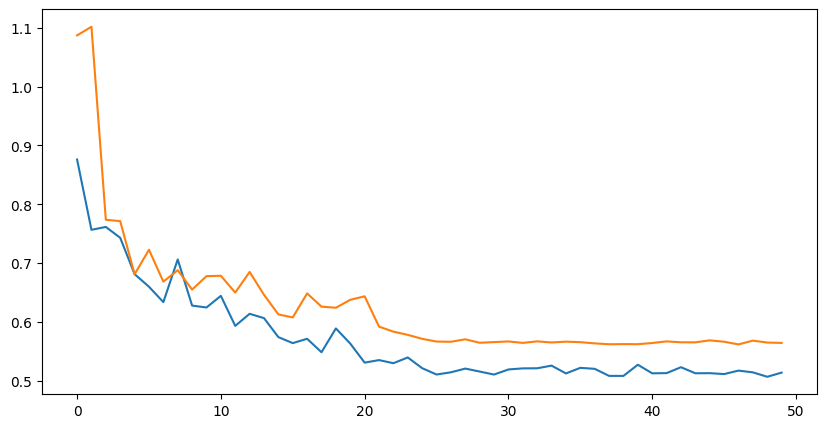

In [12]:
plt.figure(figsize= (10,5))
plt.plot(TrainLoss_list1)
plt.plot(val_losses)

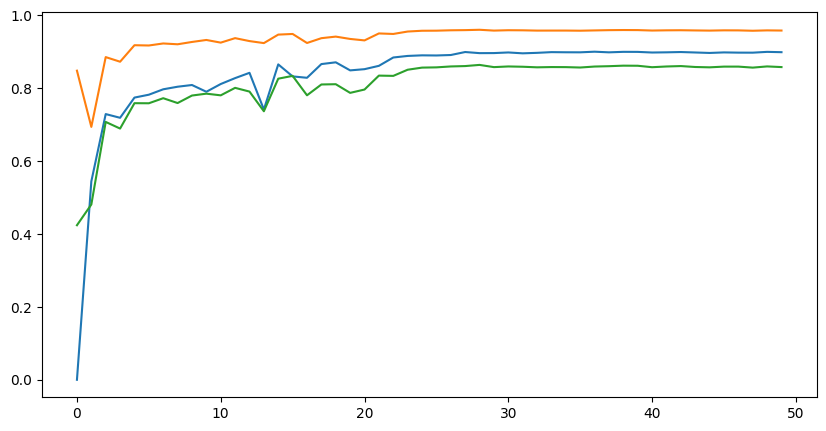

In [13]:
plt.figure(figsize= (10,5))
plt.plot(valScore_list1)
plt.plot(val_accs)
plt.plot(val_mious)